In [3]:
import os, glob
import cv2, numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import skimage
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from scipy.ndimage.measurements import label
import sklearn

In [4]:
#IMGS_INFO = '/Users/sarthak/Downloads/torrents/data_1_10.11.13.14f.15.17.18.19/'
IMGS_INFO = '/home/carnd/data_drive/data/didi-data/'
imgs = glob.glob(IMGS_INFO + '/**/labelled/*intensity*.png')
print ('Number of images:', len(imgs))

Number of images: 16440


In [15]:
#Create car and noncar data
centroid_data = []
for idx, img_file in enumerate(imgs):
    centroid_file = os.path.join(img_file[:-4] + '.txt').replace('labelled', '')
    data_line = open(centroid_file, 'r').readlines()[0].split(' ')
    if data_line[0][0] == '[' and data_line[1][0] == '[':
        centroid_data.append([float(data_line[0][1:-2]), float(data_line[1][1:-2]), float(data_line[2])])

In [22]:
car_images, non_car_images = [], []
for img_file, centroid in zip(imgs, centroid_data):
    if centroid[2] < 5.0:
        continue
    centroid_x = int(centroid[0])
    single_channel_im1 = cv2.imread(img_file)[:, :, 0]
    single_channel_im2 = cv2.imread(img_file.replace('intensity', 'distance'))[:, :, 0]
    single_channel_im = np.vstack((single_channel_im1, single_channel_im2))
    car_images.append(single_channel_im[:, (centroid_x - 50) : (centroid_x + 50)])
    if car_images[-1].shape[0] == 0 or car_images[-1].shape[1] == 0:
        if (centroid_x - 50) < 0:
            car_images[-1] = single_channel_im[:, 0:100]
        else:
            car_images[-1] = single_channel_im[:, -100:-1]
    for x1 in range(0, centroid_x - 50, 100)[:-1]:
        non_car_images.append(single_channel_im[:, x1 : (x1 + 100)])
    for x2 in range(centroid_x + 50, single_channel_im.shape[1] - 1, 100)[:-1]:
        non_car_images.append(single_channel_im[:, x2 : (x2 + 100)])
    if non_car_images[-1].shape[1] == 0:
        print ('Could not process:', img_file)

In [33]:
print('Number of car images:', len(car_images), ' with shape:', car_images[0].shape)
print('Number of non car images:', len(non_car_images), ' with shape:', non_car_images[0].shape)
min_img_count = min([len(car_images), len(non_car_images), 10000])
print('Number of min image count:', len(non_car_images), ' with shape:', non_car_images[0].shape)

Number of car images: 12811  with shape: (138, 100)
Number of non car images: 52749  with shape: (138, 100)
Number of min image count: 52749  with shape: (138, 100)


In [34]:
# Define a function to extract features from a list of images
def extract_features(imgs):
    features = []
    # Iterate through the list of images
    for feature_image in imgs:
        features.append(np.reshape(feature_image, (feature_image.shape[0], feature_image.shape[1], -1)))
    # Return list of feature vectors
    return features

In [35]:
def generate_features(vehicle_imgs, non_vehicle_imgs):
    car_features = extract_features(vehicle_imgs)
    not_car_features = extract_features(non_vehicle_imgs)
    print ('Size of car features:', np.array(car_features).shape)
    print ('Size of non car features:', np.array(not_car_features).shape)
    return car_features, not_car_features

In [36]:
car_features, not_car_features = generate_features(car_images, non_car_images)

Size of car features: (12811, 138, 100, 1)
Size of non car features: (52749, 138, 100, 1)


In [37]:
#Use even number of samples for training the classifying the window
non_car_images2 = non_car_images[:min_img_count]
not_car_features2 = not_car_features[:min_img_count]
car_images2 = car_images[:min_img_count]
car_features2 = car_features[:min_img_count]

print ('Size of car features after sampling:', np.array(car_features2).shape)
print ('Size of non car features after sampling:', np.array(not_car_features2).shape)

labels = np.hstack((np.ones(len(car_features2)), np.zeros(len(not_car_features2))))
X = np.vstack((car_features2, not_car_features2)).astype(np.float64)

Size of car features after sampling: (10000, 138, 100, 1)
Size of non car features after sampling: (10000, 138, 100, 1)


In [38]:
# Split up data into randomized training and test sets
print ('Size of car features:', np.array(car_features2).shape)
print ('Size of non car features:', np.array(not_car_features2).shape)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=rand_state)

Size of car features: (10000, 138, 100, 1)
Size of non car features: (10000, 138, 100, 1)


In [39]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, Dropout, Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras import optimizers
import keras
from keras.backend import tf as ktf

model = Sequential()
# Crop the images with 65 px from top and 25 px from bottom
#model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160, 320, 3)))
# Normalize the image
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(138, 100, 1)))

#NVIDA End to End Learning
model.add(Convolution2D(24, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Convolution2D(36, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1, 1)))

model.add(Flatten())

model.add(Dense(4224))
model.add(Dropout(0.75))
model.add(Dense(3000))
model.add(Dropout(0.75))
model.add(Dense(2000))
model.add(Dense(1000))
model.add(Dense(500))

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.add(Activation('sigmoid'))
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 138, 100, 1)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 67, 48, 24)    624         lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 32, 22, 36)    21636       convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 14, 9, 48)     43248       convolution2d_7[0][0]            
___________________________________________________________________________________________

In [40]:
from keras.models import Model
import matplotlib.pyplot as plt

# Save the model if validation loss improves from the last best model
modelCheckpoint = keras.callbacks.ModelCheckpoint('best_model.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose=1)
# Save the training log
csv_logger = keras.callbacks.CSVLogger('training.log')
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

#Fit the model using the generator
history_object = model.fit(X_train, y_train, batch_size=1024, 
                                     #samples_per_epoch = len(X_train),
                                     nb_epoch=20,
                                     #nb_val_samples = len(X_test),
                                     validation_data = (X_test, y_test),
                                     verbose=1,
                                     callbacks=[modelCheckpoint, csv_logger])

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 15s - loss: 0.6898 - acc: 0.5459 - val_loss: 0.6681 - val_acc: 0.6077
Epoch 2/20
16000/16000 [==============================] - 14s - loss: 0.6451 - acc: 0.6375 - val_loss: 0.6221 - val_acc: 0.6667
Epoch 3/20
16000/16000 [==============================] - 14s - loss: 0.6101 - acc: 0.6723 - val_loss: 0.5974 - val_acc: 0.6880
Epoch 4/20
16000/16000 [==============================] - 14s - loss: 0.5968 - acc: 0.6837 - val_loss: 0.5831 - val_acc: 0.6965
Epoch 5/20
16000/16000 [==============================] - 14s - loss: 0.5773 - acc: 0.7012 - val_loss: 0.5731 - val_acc: 0.7075
Epoch 6/20
16000/16000 [==============================] - 14s - loss: 0.5580 - acc: 0.7139 - val_loss: 0.5630 - val_acc: 0.7205
Epoch 7/20
16000/16000 [==============================] - 14s - loss: 0.5467 - acc: 0.7208 - val_loss: 0.5474 - val_acc: 0.7267
Epoch 8/20
16000/16000 [==============================]

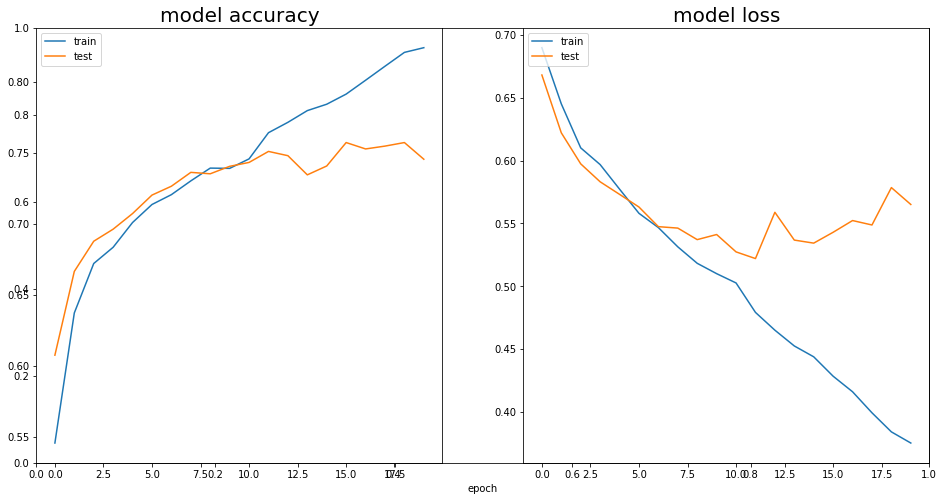

In [41]:
plt.clf()
f = plt.figure(figsize=(16, 8))
#plt.ylabel('accuracy')
plt.xlabel('epoch')

# summarize history for accuracy
ax1 = f.add_subplot(1, 2, 1)
ax1.plot(history_object.history['acc'])
ax1.plot(history_object.history['val_acc'])
ax1.set_title('model accuracy', fontsize=20)
ax1.legend(['train', 'test'], loc='upper left')

#summarize history for loss
ax2 = f.add_subplot(1, 2, 2)
ax2.plot(history_object.history['loss'])
ax2.plot(history_object.history['val_loss'])
ax2.set_title('model loss', fontsize=20)
ax2.legend(['train', 'test'], loc='upper left')

plt.show()
plt.savefig('model_loss.png')

In [42]:
from keras.models import load_model
final_model = load_model('best_model.h5')

In [77]:
#TEST on some extra leftover data - unseen by model at all!
car_images_test = car_images[min_img_count:]
car_features_test = car_features[min_img_count:]
non_car_images_test = non_car_images[min_img_count:(min_img_count + len(car_images_test))]
not_car_features_test = not_car_features[min_img_count:(min_img_count + len(car_images_test))]

car_features_prediction = final_model.predict(np.array(car_features_test))
print(np.array(car_features_test).shape)
not_car_features_prediction = model.predict(np.array(not_car_features_test))
print(np.sum(car_features_prediction > 0.75), ' classified correctly out of: ', len(car_features_test))
print(np.sum(not_car_features_prediction <= 0.75), ' classified correctly out of: ', len(not_car_features_test))

(2811, 138, 100, 1)
1596  classified correctly out of:  2811
1902  classified correctly out of:  2811


Number of images: 16440


In [206]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(100, 138), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, final_model, threshold=0.75):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        #4) Extract features for that window using single_img_features()
        single_win_features = np.reshape(test_img, (test_img.shape[0], test_img.shape[1], -1))
        #5) Predict using your classifier
        prediction = final_model.predict(np.array([single_win_features]))
        #7) If positive (prediction == 1) then save the window
        if prediction > threshold:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes_and_return_centroid(img, labels):
    bboxes = []
    bbox_centers = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        bboxes.append(bbox)
        bbox_center = [bbox[0][0] + bbox[1][0], bbox[0][1] + bbox[1][1]]
        bbox_centers.append(bbox_center)
        #print('bbox:', bbox)
        #print('bbox_center:', bbox_center)
    # Return the image
    return img, np.array(bbox_centers) * 0.5

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [207]:
TEST_IMGS_INFO = '/home/carnd/data_drive/data/round_1_test/19_f2/unlabelled/'
test_imgs = glob.glob(TEST_IMGS_INFO + '*intensity*.png')
print ('Number of images:', len(test_imgs))

Number of images: 6432


In [208]:
single_channel_im1 = cv2.imread(test_imgs[0])[:, :, 0]
single_channel_im2 = cv2.imread(test_imgs[0].replace('intensity', 'distance'))[:, :, 0]
single_channel_im = np.vstack((single_channel_im1, single_channel_im2))
windows = slide_window(single_channel_im)
print('All windows:', windows)

All windows: [((0, 0), (100, 138)), ((25, 0), (125, 138)), ((50, 0), (150, 138)), ((75, 0), (175, 138)), ((100, 0), (200, 138)), ((125, 0), (225, 138)), ((150, 0), (250, 138)), ((175, 0), (275, 138)), ((200, 0), (300, 138)), ((225, 0), (325, 138)), ((250, 0), (350, 138)), ((275, 0), (375, 138)), ((300, 0), (400, 138)), ((325, 0), (425, 138)), ((350, 0), (450, 138)), ((375, 0), (475, 138)), ((400, 0), (500, 138)), ((425, 0), (525, 138)), ((450, 0), (550, 138)), ((475, 0), (575, 138)), ((500, 0), (600, 138))]


In [209]:
#Image has to be normalized between 0 to 255
def get_windows_detected(image, windows):
    hot_windows = search_windows(image, windows, final_model)                       

    draw_image = np.copy(image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    # Add heat to each box in box list
    heat = np.zeros_like(image).astype(np.float)
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, centers = draw_labeled_bboxes_and_return_centroid(np.copy(image), labels)
    
    return window_img, draw_img, heatmap, centers

Processing: 500 [[87.0, 68.5], [399.5, 68.5]]
Processing: 1000 [[224.5, 68.5], [424.5, 68.5]]
Processing: 1500 [[112.0, 68.5], [337.0, 68.5]]
Processing: 2000 [[124.5, 68.5], [337.0, 68.5]]
Processing: 2500 [[162.0, 68.5]]
Processing: 3000 [[87.0, 68.5]]
Processing: 3500 [[262.0, 68.5]]
Processing: 4000 [[399.5, 68.5]]
Processing: 4500 [[312.0, 68.5]]
Processing: 5000 [[362.0, 68.5]]
Processing: 5500 [[387.0, 68.5]]
Processing: 6000 [[474.5, 68.5]]


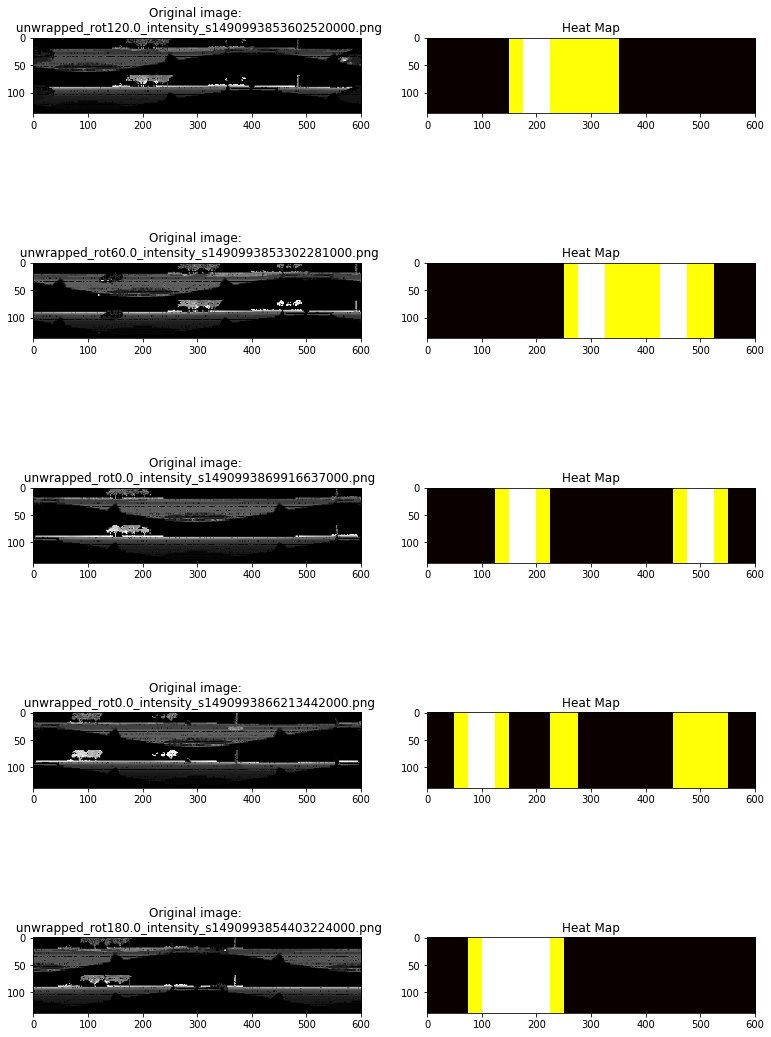

Processing took: 14.65386608839035 minutes


In [212]:
plt.clf()
fig = plt.figure(figsize=(20, 20))
col_size = 3
start_time = time.time()
number_of_images_to_show = 5
indices_to_display = sklearn.utils.resample(range(len(test_imgs)), n_samples=number_of_images_to_show, replace=False)
center_data = {}

for idx_tmp, test_img in enumerate(test_imgs):
    single_channel_im1 = cv2.imread(test_img)[:, :, 0]
    single_channel_im2 = cv2.imread(test_img.replace('intensity', 'distance'))[:, :, 0]
    single_channel_im = np.vstack((single_channel_im1, single_channel_im2))
    hot_windows = search_windows(single_channel_im, windows, final_model)
    #print('Hot windows:', hot_windows)
    
    window_img, draw_img, heatmap, centers = get_windows_detected(single_channel_im, windows)
    center_data[os.path.basename(test_img)] = centers.tolist()
    
    if idx_tmp % 500 == 0 and idx_tmp > 0:
        print ('Processing:', idx_tmp, centers.tolist())
    
    if idx_tmp in indices_to_display:
        idx = indices_to_display.index(idx_tmp)
        idx1 = idx * col_size + 1

        ax1 = fig.add_subplot(number_of_images_to_show, col_size, idx1)
        ax1.set_title('Original image: \n ' + os.path.basename(test_img))
        #ax1.imshow(window_img, cmap='gray')
        ax1.imshow(single_channel_im, cmap='gray')

        ax2 = fig.add_subplot(number_of_images_to_show, col_size, idx1 + 1)
        #ax2.set_title('Car Positions')
        #ax2.imshow(draw_img)

        #ax3 = fig.add_subplot(number_of_images_to_show, col_size, idx1 + 2)
        ax2.set_title('Heat Map')
        ax2.imshow(heatmap, cmap='hot')
    
plt.show()
fig.tight_layout()
end_time = time.time()
print('Processing took:', (end_time - start_time) / 60.0, 'minutes')


In [213]:
print(center_data)

{'unwrapped_rot195.0_intensity_s1490993859807889000.png': [[149.5, 68.5], [324.5, 68.5]], 'unwrapped_rot240.0_intensity_s1490993859607722000.png': [[74.5, 68.5], [249.5, 68.5], [462.0, 68.5]], 'unwrapped_rot15.0_intensity_s1490993847397167000.png': [[399.5, 68.5]], 'unwrapped_rot285.0_intensity_s1490993853402335000.png': [[112.0, 68.5], [512.0, 68.5]], 'unwrapped_rot15.0_intensity_s1490993865012389000.png': [[87.0, 68.5], [499.5, 68.5]], 'unwrapped_rot15.0_intensity_s1490993862310062000.png': [[137.0, 68.5], [487.0, 68.5]], 'unwrapped_rot45.0_intensity_s1490993866013293000.png': [[474.5, 68.5]], 'unwrapped_rot240.0_intensity_s1490993868215168000.png': [[99.5, 68.5], [362.0, 68.5]], 'unwrapped_rot60.0_intensity_s1490993868915771000.png': [[87.0, 68.5]], 'unwrapped_rot105.0_intensity_s1490993864311810000.png': [[349.5, 68.5]], 'unwrapped_rot285.0_intensity_s1490993864211696000.png': [[237.0, 68.5]], 'unwrapped_rot0.0_intensity_s1490993844594707000.png': [[199.5, 68.5], [499.5, 68.5]], 'u